# Metro Canary

#### Required Modules

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
matplotlib.pylab.rcParams['figure.figsize'] = (14.0, 8.0)

## Load/parse the data

#### Load in Tweets as a DataFrame

In [2]:
tweetfile = 'tweets.csv'
tweets = pd.read_csv(tweetfile,delimiter='\t')
tweets['timestamp'] = [pd.to_datetime(t,unit='s') for t in tweets.tweettime]
tweets.index = tweets['timestamp']
tweets = tweets.drop(['tweettime'],axis=1)
tweets_unique = tweets.drop_duplicates(subset='tweetid')
tweets_unique = tweets_unique.sort('tweetid')

#### Load in Metro Rail Service Reports (http://www.wmata.com/rail/service_reports/viewReportArchive.cfm) as a DataFrame

In [3]:
incidentfile = 'incidents.csv'
incidents = pd.read_csv(incidentfile)
incidents.index = incidents['timestamp']
incidents = incidents[incidents['delay'] >= 10]
incidents = incidents.sort('timestamp')

#### Define functions related to parsing Tweets and Service Reports

In [4]:
def grabTweetText(tS):
    tweetText = []
    if (len(tS) == 0):
        return ''
    else:
        tweetText = (tS.to_string(columns=['tweettext'],index=False,header=False,index_names=False))
        return tweetText

def getIncidentInfo(iS):
    incidentInfo = []
    if (len(iS) > 0):
        incidentInfo = 1.
    else:
        incidentInfo = 0.
    return incidentInfo

#### We're binning Tweets and Incidents in 15 minute bins

In [5]:
time_index = pd.date_range('2015-07-19 00:00:00',tweets_unique.timestamp[-1],freq='15t')

#### Bin number of Tweets, number of incidents, the text content of Tweets, and pertinent information about incidents

In [6]:
numTweets = []
tweetText = []
numIncidents = []
incidentInfo = []
for i in range(1,len(time_index)):
    tweetSlice = tweets_unique[str(time_index[i-1]):str(time_index[i])]
    incidentSlice = incidents[str(time_index[i-1]):str(time_index[i])]
    numTweets.append(len(tweetSlice))
    tweetText.append(grabTweetText(tweetSlice))
    numIncidents.append(len(incidentSlice))
    incidentInfo.append(getIncidentInfo(incidentSlice))

#### Plot number of Tweets and incidents as a function of time

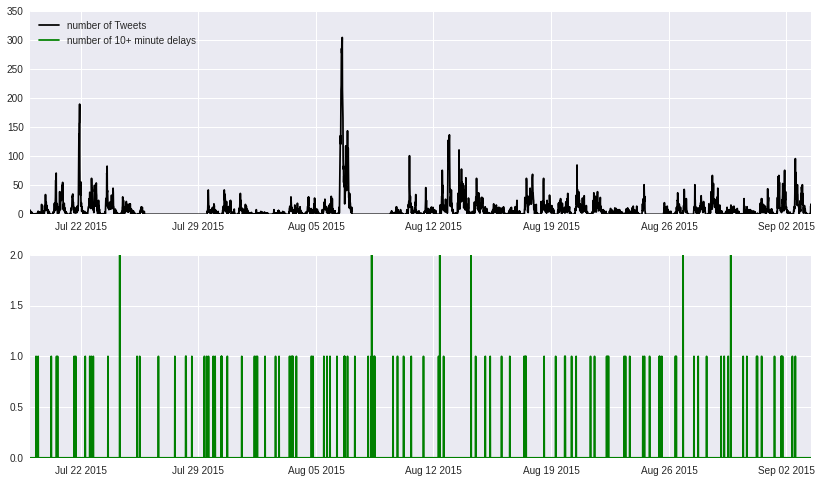

In [7]:
plt.subplot(211)
nT_plot, = plt.plot(time_index[1:len(time_index)],numTweets, color = 'k')
plt.subplot(212)
nI_plot, = plt.plot(time_index[1:len(time_index)],numIncidents, color ='g')
plt.subplot(211)
plt.legend([nT_plot, nI_plot], ['number of Tweets', 'number of 10+ minute delays'],loc='upper left')

#### Define targeted word searches (e.g. 'delay')

In [8]:
def tweets_word_frequency( tweets ):
    # remove usernames, hyperlinks, numbers, etc.
    # tweets = re.sub('[@][A-Za-z0-9]+','', tweets)
    tweets = re.sub('http://[A-Za-z\.\/0-9]+','', tweets)
    tweets = re.sub('https://[A-Za-z\.\/0-9]+','', tweets)
    tweets = re.sub('[0-9]+', '', tweets)
    tweets = tweets.replace('\'','')                          
    words = tweets.lower().split()                             
    # define tallies - words related to delays, words related to metro stations or lines, and words related to
    # people tweeting to the various complaint clearinghouses.
    delay_related_words = 0
    line_related_words = 0
    angry_twits_related_words = 0
    for word in words:
        if word in ['delay','delays','residual','tracking','single']:
            delay_related_words += 1
        elif word in ['red','orange','blue','silver','yellow','green','line','station','train']:
            line_related_words += 1
        elif word in ['RT','@wmata','@unsuckdcmetro','@metrorailinfo','@fixwmata','@dcmetrosucks','@fixmetro']:
            angry_twits_related_words += 1
        else:
            pass
    return delay_related_words, line_related_words, angry_twits_related_words

#### Then perform the search

In [9]:
DRW = []
LRW = []
ATRW = []
for tT in tweetText:
    drwnum, lrwnum, atrwnum = tweets_word_frequency(tT)
    DRW.append(drwnum)
    LRW.append(lrwnum)
    ATRW.append(atrwnum)

In [10]:
training_DF = pd.DataFrame({'totalTweets' : numTweets, 'DRW' : DRW, 'LRW' : LRW, 'ATRW' : ATRW, 'IncidentInfo' : incidentInfo})
training_DF.index = time_index[1:len(time_index)]

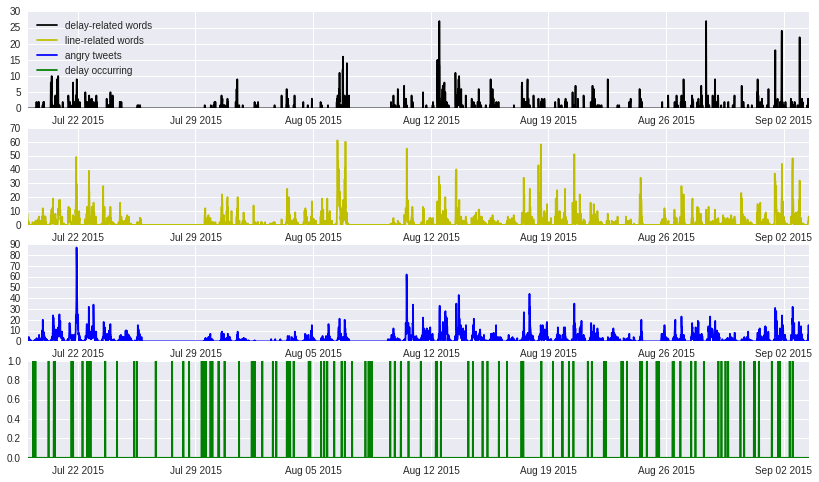

In [11]:
plt.subplot(411)
DRW_plot, = plt.plot(time_index[1:len(time_index)],training_DF.DRW, color = 'k')
plt.subplot(412)
LRW_plot, = plt.plot(time_index[1:len(time_index)],training_DF.LRW, color ='y')
plt.subplot(413)
ATRW_plot, = plt.plot(time_index[1:len(time_index)],training_DF.ATRW, color ='b')
plt.subplot(414)
iI_plot, = plt.plot(time_index[1:len(time_index)],training_DF.IncidentInfo, color ='g')
plt.subplot(411)
plt.legend([DRW_plot, LRW_plot, ATRW_plot, iI_plot], ['delay-related words', 'line-related words', 'angry tweets', 'delay occurring'], loc='upper left')


## Train a Decision Tree classifier

In [12]:
x_train_data = training_DF[['totalTweets','DRW','LRW','ATRW']]
y_train_data = training_DF['IncidentInfo']

In [13]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_data, y_train_data, test_size=0.2, random_state=1337)

In [14]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

## Make a predction!

In [15]:
y_pred = clf.predict(x_test)

In [16]:
from sklearn import metrics
print 'predicted', sum(y_pred), 'actual', sum(y_test)
print "Accuracy:", metrics.accuracy_score(y_test, y_pred)
print "Precision:", metrics.precision_score(y_test, y_pred)
print "Recall:", metrics.recall_score(y_test, y_pred)

predicted 14.0 actual 26.0
Accuracy: 0.955207166853
Precision: 0.0
Recall: 0.0


### Yikes!  Let's take a closer look.

In [17]:
y_dict = {'pred' : y_pred, 'test' : y_test.values}
y_DF = pd.DataFrame(y_dict)
y_DF.index = y_test.index
time = y_DF.index.values
predicted = y_DF['pred'].values
actual = y_DF['test'].values

(0, 2)

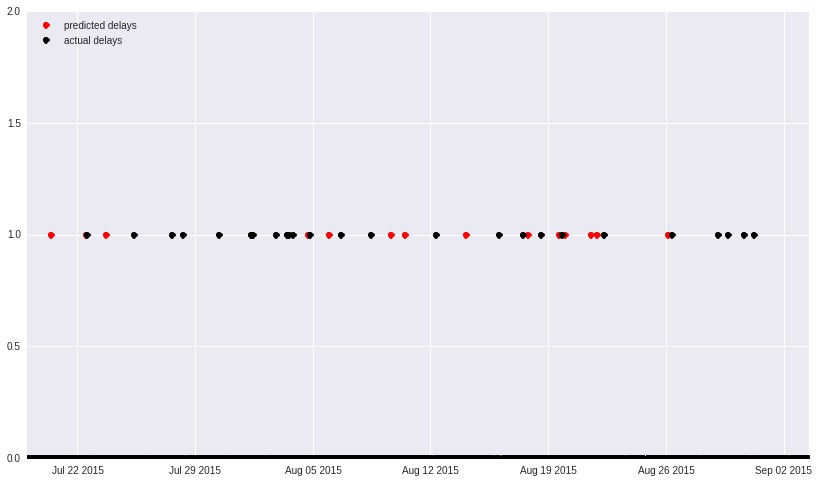

In [18]:
pred_plot, = plt.plot(time,predicted,'o',color='r')
act_plot, = plt.plot(time,actual,'o',color='k')
plt.legend([pred_plot, act_plot], ['predicted delays', 'actual delays'],loc='upper left')
plt.ylim(0,2)

#### OK, it looks like we're not far off on at least 5-6 of them.